<a href="https://www.kaggle.com/code/samithsachidanandan/bilstm-fake-news-improved?scriptVersionId=287860924" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Published on 15 December, 2025. By Prata, Marília (mpwolke)

**Acknoledgement :** [mpwolke](https://www.kaggle.com/code/mpwolke/bilstm-fake-news)

Just performed small changes to improve the score. 

## Import Libraries

In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-m

In [2]:


import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import plotly.io as pio
pio.renderers.default = 'iframe'

import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px


import warnings
warnings.filterwarnings('ignore')

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

2025-12-22 17:45:35.952536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766425536.152820      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766425536.224739      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load csv (train) file

In [3]:
df = pd.read_csv("/kaggle/input/fake-news-detection-dataset/train.csv")
df.head(3)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1


## info() method

We have missing values on title, author and text columns.

In [4]:
print(df.info())
df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB
None


label
1    10413
0    10387
Name: count, dtype: int64

## Helper Function

Helper function to clean text.

In [5]:
#By Arif Miah https://www.kaggle.com/code/miadul/toxic-tweet-classifier-using-deep-learning/notebook

def clean_title(text):
    text = str (text) #Avoid Float has no attribute Lower
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

## apply method

In [6]:
#By Arif Miah https://www.kaggle.com/code/miadul/toxic-tweet-classifier-using-deep-learning/notebook

df['clean_title'] = df['title'].apply(clean_title)
df[['title', 'clean_title']].head()

,title,clean_title
0,House Dem Aide: We Didn’t Even See Comey’s Let...,house dem aide we didn’t even see comey’s lett...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",flynn hillary clinton big woman on campus brei...
2,Why the Truth Might Get You Fired,why the truth might get you fired
3,15 Civilians Killed In Single US Airstrike Hav...,civilians killed in single us airstrike have b...
4,Iranian woman jailed for fictional unpublished...,iranian woman jailed for fictional unpublished...


## train/test/split

In [7]:
#By Arif Miah https://www.kaggle.com/code/miadul/toxic-tweet-classifier-using-deep-learning/notebook

X = df['clean_title'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## oov_token

In [8]:
#By Arif Miah https://www.kaggle.com/code/miadul/toxic-tweet-classifier-using-deep-learning/notebook

vocab_size = 20000
max_len = 100
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [9]:
#By Arif Miah https://www.kaggle.com/code/miadul/toxic-tweet-classifier-using-deep-learning/notebook

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

## Model

In [10]:
#By Arif Miah https://www.kaggle.com/code/miadul/toxic-tweet-classifier-using-deep-learning/notebook

embedding_dim = 128

lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),  
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),  
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


I0000 00:00:1766425552.883806      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Epochs

In [11]:
#By Arif Miah https://www.kaggle.com/code/miadul/toxic-tweet-classifier-using-deep-learning/notebook

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=10, #Original 10
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/10


I0000 00:00:1766425560.675649      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


234/234 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.8209 - loss: 0.3641 - val_accuracy: 0.9543 - val_loss: 0.1291
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.7467 - loss: 0.6332 - val_accuracy: 0.9273 - val_loss: 0.2428
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9565 - loss: 0.1654 - val_accuracy: 0.9297 - val_loss: 0.2219


In [12]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 100, 128)         │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (64, 100, 256)         │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 100, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (64, 128)              │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (64, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,987,525 (34.28 MB)

 Trainable params: 2,995,841 (11.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,991,684 (22.86 MB)

## BiLSTM (Bidirectional Long Short-Term Memory)

"A Bidirectional Long Short-Term Memory (BiLSTM) network is a type of recurrent neural network (RNN) that processes sequence data in both a forward and backward direction simultaneously. This approach allows the model to capture the full context of a sequence, leveraging information from both past (left-to-right) and future (right-to-left) time steps."

**Advantages over Standard LSTM**

"Compared to a standard LSTM which only processes sequences in one direction and has access only to past context, BiLSTMs process sequences in both directions, allowing access to both past and future context for a fuller understanding. This typically leads to better performance in tasks where full context is crucial, although it does result in a more complex architecture and higher computational cost." 

AI Overview.

In [13]:
#By Arif Miah https://www.kaggle.com/code/miadul/toxic-tweet-classifier-using-deep-learning/notebook

bilstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

bilstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [14]:
history_bilstm = bilstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8074 - loss: 0.3752 - val_accuracy: 0.9507 - val_loss: 0.1335
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9698 - loss: 0.1244 - val_accuracy: 0.9459 - val_loss: 0.1481
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9939 - loss: 0.0233 - val_accuracy: 0.9315 - val_loss: 0.2007


In [15]:
bilstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (64, 100, 128)         │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (64, 256)              │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (64, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (64, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,519,045 (32.50 MB)

 Trainable params: 2,839,681 (10.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,679,364 (21.67 MB)

## Classification report

In [16]:
#By Arif Miah https://www.kaggle.com/code/miadul/toxic-tweet-classifier-using-deep-learning/notebook

y_pred_bilstm = (bilstm_model.predict(X_test_pad) > 0.5).astype(int)

print("BiLSTM Accuracy:", accuracy_score(y_test, y_pred_bilstm))
print(classification_report(y_test, y_pred_bilstm))

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
BiLSTM Accuracy: 0.940625
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2077
           1       0.94      0.95      0.94      2083

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



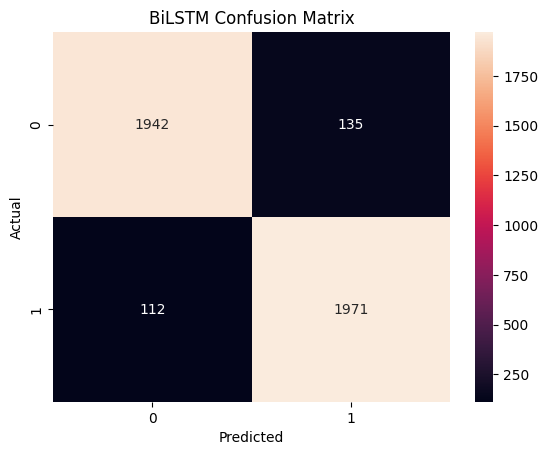

In [17]:
#By Arif Miah https://www.kaggle.com/code/miadul/toxic-tweet-classifier-using-deep-learning/notebook

cm = confusion_matrix(y_test, y_pred_bilstm)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("BiLSTM Confusion Matrix")
plt.show()

## I didn't have to handle missing values or drop columns.

That means a lot since on the previous FakeNews LSTM, with the same data, no matter I dealed missing values and dropped columns, I wasn't able to finish it. The code ran without issues here.

#Acknowledgements:

Arif Miah https://www.kaggle.com/code/miadul/toxic-tweet-classifier-using-deep-learning/notebook